# Proyecto Chatbot para INGE LEAN S.A.S

## **Visión del reto**

- **Objetivo general:** Crear un chatbot inteligente para atención al cliente en INGELEAN, capaz de evolucionar desde un sistema básico de FAQ hasta un asistente adaptativo con análisis, trazabilidad y aprendizaje incremental.
- **Resultados esperados:** Respuestas automáticas, personalizadas, rápidas (≤2s), cobertura ≥90% de preguntas frecuentes, manejo de múltiples usuarios y trazabilidad de interacciones.

### Bloque 1: Importación de Librerías

Este primer bloque es fundamental para establecer todas las herramientas y módulos necesarios a lo largo del proyecto. Incluye librerías para la manipulación de datos, procesamiento de lenguaje natural (NLP), aprendizaje automático (Machine Learning), visualización de datos y la creación de una API web.

In [1]:
# ==============================================================================
# 1. Importar Librerías Necesarias
# ==============================================================================
import pandas as pd # Para manipulación y análisis de datos (DataFrames)
import re # Para operaciones con expresiones regulares (limpieza de texto)
from unicodedata import normalize # Para normalización de caracteres (eliminar acentos)
import joblib # Para serializar y deserializar modelos Python (guardar/cargar modelo y vectorizador)
import os # Para interactuar con el sistema operativo (verificar existencia de archivos)
import numpy as np # Para operaciones numéricas, especialmente con arrays

# Librerías para el Modelado de Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer # Para convertir texto en vectores numéricos (TF-IDF)
from sklearn.model_selection import train_test_split # Para dividir el dataset en conjuntos de entrenamiento y prueba
from sklearn.naive_bayes import MultinomialNB # Implementación del clasificador Naive Bayes Multinomial
from sklearn.linear_model import LogisticRegression # Implementación del clasificador de Regresión Logística
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support # Para evaluar el rendimiento del modelo

# Librerías para Visualización de Datos
import matplotlib.pyplot as plt # Para la creación de gráficos estáticos, animados e interactivos
import seaborn as sns # Basado en Matplotlib, para crear gráficos estadísticos atractivos e informativos

# Librerías para la API (Flask)
from flask import Flask, request, jsonify # Flask: microframework para crear APIs web; request: para manejar solicitudes HTTP; jsonify: para devolver respuestas JSON

# Configuración de Matplotlib para mejorar la visualización de los gráficos
plt.rcParams['figure.constrained_layout.use'] = True # Ajusta automáticamente los subplots  para ajustarse a la figura
plt.rcParams['figure.figsize'] = (10, 6) # Establece el tamaño de figura por defecto
plt.rcParams['axes.titlesize'] = 14 # Tamaño de fuente para los títulos de los ejes
plt.rcParams['axes.labelsize'] = 12 # Tamaño de fuente para las etiquetas de los ejes
plt.rcParams['xtick.labelsize'] = 10 # Tamaño de fuente para las etiquetas del eje X
plt.rcParams['ytick.labelsize'] = 10 # Tamaño de fuente para las etiquetas del eje Y
plt.rcParams['legend.fontsize'] = 10 # Tamaño de fuente para la leyenda
plt.rcParams['font.sans-serif'] = ['Arial'] # Puedes cambiar a otra fuente si lo deseas (ej. 'DejaVu Sans' en Linux/Windows)

In [2]:
# ==============================================================================
# 0. Observación Inicial del Dataset
# ==============================================================================

import pandas as pd # Importar pandas para cargar el archivo
import os # Para verificar la existencia del archivo

print("--- Primer Paso: Observación Inicial del Dataset ---")

# Definir la ruta completa del archivo del dataset
dataset_path = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\INGE LEAN S.A.S\FAQs_Ingelean.xlsx"

# Verificar si el archivo existe antes de intentar cargarlo
if not os.path.exists(dataset_path):
    print(f"ERROR: El archivo no fue encontrado en la ruta especificada:\n{dataset_path}")
    print("Asegúrate de que la ruta sea correcta y el archivo exista.")
    # Si el archivo no existe, no podemos continuar, así que salimos.
    exit()

try:
    # Intentar cargar el dataset asumiendo que la primera fila (header=0) contiene los nombres de las columnas.
    # Usamos sheet_name='Sheet1' por defecto. Si tu hoja tiene otro nombre, ajústalo aquí.
    df_raw = pd.read_excel(dataset_path, header=0, sheet_name='Sheet1')
    print(f"Dataset cargado exitosamente para observación desde: {dataset_path} con header=0.")
except Exception as e:
    print(f"ERROR: Falló la carga del archivo Excel para observación. Error: {e}")
    print("Posibles causas:")
    print("  - El archivo Excel está corrupto o abierto en otra aplicación.")
    print("  - El nombre de la hoja ('Sheet1') no es correcto.")
    print("  - La fila del encabezado no es la primera (prueba con header=None o header=otra_fila si sospechas).")
    exit()

print("\n--- Información del DataFrame sin modificar (df_raw.info()): ---")
df_raw.info()

print("\n--- Primeras 5 filas del DataFrame sin modificar (df_raw.head()): ---")
print(df_raw.head())

print("\n--- Nombres de las columnas tal como se leyeron (df_raw.columns.tolist()): ---")
print(df_raw.columns.tolist())

print("\n--- Conteos de valores en la columna 'CATEGORIA' (si existe y es la correcta): ---")
# Intentamos acceder a 'CATEGORIA' tal como se lee, para ver su contenido
if 'CATEGORIA' in df_raw.columns:
    print(df_raw['CATEGORIA'].value_counts())
elif 'categoria' in df_raw.columns: # Por si acaso ya está en minúsculas
    print(df_raw['categoria'].value_counts())
else:
    print("La columna 'CATEGORIA' o 'categoria' no se encontró directamente.")

print("\n--- Fin de la Observación Inicial ---")

--- Primer Paso: Observación Inicial del Dataset ---
Dataset cargado exitosamente para observación desde: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\INGE LEAN S.A.S\FAQs_Ingelean.xlsx con header=0.

--- Información del DataFrame sin modificar (df_raw.info()): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CATEGORIA     1914 non-null   object
 1   SUBCATEGORIA  1914 non-null   object
 2   PREGUNTA      1914 non-null   object
 3   RESPUESTA     1914 non-null   object
dtypes: object(4)
memory usage: 59.9+ KB

--- Primeras 5 filas del DataFrame sin modificar (df_raw.head()): ---
   CATEGORIA          SUBCATEGORIA  \
0  Generales  Software a la Medida   
1  Generales  Software a la Medida   
2  Generales  Software a la Medida   
3  Generales  Software a la Medida   
4  Generales  Software a la Medida   

                  

In [3]:
import re
from unicodedata import normalize

# Función auxiliar para limpiar texto: minúsculas, sin acentos, sin caracteres especiales
# Coloca esta función al principio de tu script, después de las importaciones principales.
def clean_text(text):
    text = str(text).lower()
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^a-z0-9\s¿?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ... luego sigue con tu Bloque 2: Preparación del Dataset

### Bloque 2: Preparación del Dataset

Este bloque se encarga de cargar los datos de las preguntas frecuentes (FAQs) desde el archivo CSV, limpiarlos y transformarlos al formato requerido para el entrenamiento del modelo. La limpieza de texto es crucial para estandarizar las entradas y mejorar la efectividad del procesamiento del lenguaje natural.

In [4]:
# ==============================================================================
# 2. Preparación del Dataset (VERSIÓN CORREGIDA Y LISTA PARA USAR)
# ==============================================================================

print("Paso 2: Preparación del Dataset")

# Definir la ruta completa del archivo del dataset
dataset_path = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\INGE LEAN S.A.S\FAQs_Ingelean.xlsx"

# NOTA: La función 'clean_text' debe estar definida globalmente (fuera de esta función)
# para que esté disponible aquí y en la API de Flask.

# Función para cargar y limpiar el dataset
def load_and_clean_dataset(file_path):
    """
    Carga el dataset desde un archivo Excel, estandariza los nombres de las columnas
    confirmados por la observación, y limpia el texto de las preguntas.
    """
    df_temp = None # Inicializamos df_temp a None

    try:
        # Cargamos el dataset con header=0 y sheet_name='Sheet1'
        # Basado en la observación, sabemos que estos son los valores correctos.
        df_temp = pd.read_excel(file_path, header=0, sheet_name='Sheet1')
        print(f"Dataset cargado exitosamente desde: {file_path} con header=0.")
    except FileNotFoundError:
        print(f"ERROR FATAL: El archivo NO fue encontrado en la ruta especificada:\n{file_path}")
        print("Por favor, verifica que la ruta sea correcta y que el archivo exista.")
        exit(1)
    except Exception as e:
        print(f"ERROR FATAL: Falló la carga del archivo Excel '{file_path}'. Error: {e}")
        print("Asegúrate de que el archivo no esté corrupto y que el nombre de la hoja ('Sheet1') sea el adecuado.")
        exit(1)

    # --- DEBUGGING (mantener para confirmación inicial, luego puedes borrar o comentar) ---
    print("\nDEBUG: Columnas del DataFrame justo después de la carga (antes de renombrar):")
    print(df_temp.columns.tolist())
    # --- FIN DEBUGGING ---

    # Definir el mapeo de nombres de columna:
    # 'Clave': Nombre de la columna TAL COMO APARECE en el Excel (confirmado por la observación)
    # 'Valor': Nombre de la columna ESTANDARIZADO que usaremos en el código
    column_mapping = {
        'CATEGORIA': 'categoria',
        'PREGUNTA': 'pregunta',
        'RESPUESTA': 'respuesta' # <--- CORRECCIÓN CONFIRMADA: ES 'RESPUESTA' (singular)
    }
    
    # Aplicar el renombrado. Si alguna de las claves en column_mapping no existe en df_temp.columns,
    # el parámetro errors='raise' (por defecto en rename) lanzaría un error, lo cual es bueno.
    # Pero ya validamos esto con la observación.
    df_temp = df_temp.rename(columns=column_mapping)

    # --- DEBUGGING (mantener para confirmación inicial, luego puedes borrar o comentar) ---
    print("\nDEBUG: Columnas del DataFrame después de renombrar:")
    print(df_temp.columns.tolist())
    # --- FIN DEBUGGING ---

    # Eliminar columnas irrelevantes como 'SUBCATEGORIA' y '#' (si existe)
    # errors='ignore' evita que el script falle si alguna de estas columnas no está presente.
    df_temp = df_temp.drop(columns=['SUBCATEGORIA', '#'], errors='ignore')

    # Aplicar la función de limpieza al texto de las preguntas
    # Asegúrate de que 'clean_text' está definida en el Bloque 1 o globalmente.
    df_temp['pregunta'] = df_temp['pregunta'].apply(clean_text)

    # Verificar y manejar valores nulos después de las transformaciones
    if df_temp.isnull().sum().any():
        print("Advertencia: Se encontraron valores nulos después de la limpieza. Eliminando filas con valores nulos.")
        df_temp.dropna(inplace=True)
        df_temp.reset_index(drop=True, inplace=True)

    return df_temp

# Cargar y preparar el dataset final
df = load_and_clean_dataset(dataset_path)

print("\n--- Información del DataFrame después de la limpieza final: ---")
df.info()
print("\n--- Primeras 5 filas del DataFrame limpio final: ---")
print(df.head())
print("\n--- Distribución de Categorías (Intenciones) final: ---")
print(df['categoria'].value_counts())

Paso 2: Preparación del Dataset
Dataset cargado exitosamente desde: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\INGE LEAN S.A.S\FAQs_Ingelean.xlsx con header=0.

DEBUG: Columnas del DataFrame justo después de la carga (antes de renombrar):
['CATEGORIA', 'SUBCATEGORIA', 'PREGUNTA', 'RESPUESTA']

DEBUG: Columnas del DataFrame después de renombrar:
['categoria', 'SUBCATEGORIA', 'pregunta', 'respuesta']

--- Información del DataFrame después de la limpieza final: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   categoria  1914 non-null   object
 1   pregunta   1914 non-null   object
 2   respuesta  1914 non-null   object
dtypes: object(3)
memory usage: 45.0+ KB

--- Primeras 5 filas del DataFrame limpio final: ---
   categoria                                           pregunta  \
0  Generales                  que tipo de software 

In [5]:
# ==============================================================================
# 2.5. Componente de Comprensión Semántica (Manejo de Paráfrasis)
# ==============================================================================

print("\nPaso 2.5: Configurando Componente de Comprensión Semántica para Paráfrasis")

# Intentar importar la librería sentence-transformers. Si falla, la funcionalidad no estará disponible.
try:
    from sentence_transformers import SentenceTransformer, util
    print("Librería 'sentence-transformers' importada exitosamente.")
except ImportError:
    print("Advertencia: La librería 'sentence-transformers' no está instalada.")
    print("Para usar la comprensión semántica, instálala ejecutando: pip install sentence-transformers")
    # Si la importación falla, deshabilitamos la funcionalidad semántica
    SentenceTransformer = None
    util = None

# Variables globales para el modelo semántico y los embeddings del dataset
semantic_model = None
df_embeddings = None

if SentenceTransformer: # Solo procede si SentenceTransformer pudo importarse
    try:
        # Cargar un modelo pre-entrenado de embeddings de frases.
        # 'paraphrase-multilingual-MiniLM-L12-v2' es un buen modelo multilingüe para tareas de paráfrasis y similitud.
        # Se descarga la primera vez que se ejecuta, luego se carga localmente.
        print("Cargando modelo de embeddings de frases (SentenceTransformer)... Esto puede tardar la primera vez.")
        semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        print("Modelo de embeddings cargado.")

        # Generar embeddings para todas las preguntas en el dataset una sola vez.
        # Estos embeddings representan el significado de cada pregunta conocida en tu FAQ.
        # df['pregunta'] debe estar ya limpio en este punto (resultado del Bloque 2).
        print("Generando embeddings para las preguntas del dataset...")
        df_embeddings = semantic_model.encode(df['pregunta'].tolist(), convert_to_tensor=True)
        print(f"Embeddings generados para {len(df_embeddings)} preguntas.")

    except Exception as e:
        print(f"ERROR: Falló al cargar o usar el modelo de embeddings semánticos: {e}")
        print("La funcionalidad de comprensión semántica (manejo de paráfrasis) estará deshabilitada.")
        semantic_model = None
        df_embeddings = None # Asegurar que esté a None si hubo un error

# --- Nota: La lógica de uso de este componente (semantic_model, df_embeddings)
# se integrará dentro de la función 'predict' de la API de Flask (Bloque 6). ---


Paso 2.5: Configurando Componente de Comprensión Semántica para Paráfrasis
Librería 'sentence-transformers' importada exitosamente.
Cargando modelo de embeddings de frases (SentenceTransformer)... Esto puede tardar la primera vez.
Modelo de embeddings cargado.
Generando embeddings para las preguntas del dataset...
Embeddings generados para 1914 preguntas.


### Bloque 3: Entrenamiento del Modelo

En este bloque, se prepara la data para el entrenamiento mediante la vectorización TF-IDF, se divide el dataset en conjuntos de entrenamiento y prueba, y se entrenan dos modelos de clasificación: Naive Bayes Multinomial y Regresión Logística. Finalmente, se evalúa y selecciona el modelo con mejor rendimiento para ser guardado y utilizado en la API.

In [6]:
# ==============================================================================
# 3. Entrenamiento del Modelo
# ==============================================================================

print("\nPaso 3: Entrenamiento del Modelo")

# Definir variables de entrada (X: preguntas) y salida (y: categorías/intenciones)
X = df['pregunta']
y = df['categoria']

# Vectorización con TF-IDF: Transforma el texto de las preguntas en una representación numérica.
# max_features=3000 limita el número de características (palabras) a las 3000 más frecuentes,
# lo que ayuda a reducir la dimensionalidad y el ruido.
vectorizer = TfidfVectorizer(max_features=3000)
X_vec = vectorizer.fit_transform(X) # Aprende el vocabulario y transforma los datos

# División del dataset en conjuntos de entrenamiento y prueba (70% train, 30% test).
# test_size=0.3 indica que el 30% de los datos se usará para prueba y el 70% para entrenamiento.
# random_state=42 asegura que la división sea la misma cada vez que se ejecute el código, para reproducibilidad.
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3, random_state=42)

# --- Modelo 1: Naive Bayes Multinomial ---
print("\nEntrenando Modelo Naive Bayes Multinomial...")
# Se elige Naive Bayes Multinomial por ser ligero y rápido para datos de texto.
model_nb = MultinomialNB() # Inicializa el modelo Naive Bayes
model_nb.fit(X_train, y_train) # Entrena el modelo con los datos vectorizados
y_pred_nb = model_nb.predict(X_test) # Realiza predicciones sobre el conjunto de prueba
acc_nb = accuracy_score(y_test, y_pred_nb) # Calcula la exactitud (accuracy) del modelo

print("\nResultados de Naive Bayes:")
print(f"Accuracy: {acc_nb:.2f}")
# Muestra un reporte detallado de precisión, recall y F1-score por clase
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_nb))

# --- Modelo 2: Regresión Logística ---
print("\nEntrenando Modelo de Regresión Logística...")
# max_iter=1000: número máximo de iteraciones para que el algoritmo converja.
# solver='liblinear': algoritmo para el problema de optimización, bueno para datasets pequeños.
# Es una alternativa si se requiere más precisión.
model_lr = LogisticRegression(max_iter=1000, solver='liblinear')
model_lr.fit(X_train, y_train) # Entrena el modelo
y_pred_lr = model_lr.predict(X_test) # Realiza predicciones
acc_lr = accuracy_score(y_test, y_pred_lr) # Calcula la exactitud

print("\nResultados de Regresión Logística:")
print(f"Accuracy: {acc_lr:.2f}")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_lr))

# --- Determinar y Guardar el Modelo Ganador ---
print("\nDeterminando y Guardando el Modelo Ganador...")
if acc_nb > acc_lr:
    print("\nEl modelo Naive Bayes tiene mejor desempeño. Guardando modelo...")
    best_model = model_nb
    joblib.dump(best_model, 'chatbot_model.pkl') # Guarda el modelo en un archivo
else:
    print("\nEl modelo de Regresión Logística tiene mejor desempeño. Guardando modelo...")
    best_model = model_lr
    joblib.dump(best_model, 'chatbot_model.pkl') # Guarda el modelo en un archivo

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl') # Guarda también el vectorizador TF-IDF
print("Modelo y vectorizador guardados exitosamente como 'chatbot_model.pkl' y 'tfidf_vectorizer.pkl'.")


Paso 3: Entrenamiento del Modelo

Entrenando Modelo Naive Bayes Multinomial...

Resultados de Naive Bayes:
Accuracy: 0.97
Reporte de clasificación:
               precision    recall  f1-score   support

Demostración       1.00      1.00      1.00        25
   Generales       1.00      0.97      0.98       124
   Repuestos       1.00      0.18      0.30        17
     Soporte       0.96      1.00      0.98       409

    accuracy                           0.97       575
   macro avg       0.99      0.79      0.82       575
weighted avg       0.97      0.97      0.96       575


Entrenando Modelo de Regresión Logística...

Resultados de Regresión Logística:
Accuracy: 1.00
Reporte de clasificación:
               precision    recall  f1-score   support

Demostración       1.00      1.00      1.00        25
   Generales       1.00      1.00      1.00       124
   Repuestos       1.00      0.94      0.97        17
     Soporte       1.00      1.00      1.00       409

    accuracy        

### Bloque 4: Visualización de Métricas de Evaluación

Este bloque genera diversas visualizaciones para entender mejor el rendimiento del modelo seleccionado (en este caso, se usa el de Naive Bayes como ejemplo para algunas gráficas, pero la lógica aplica para el mejor modelo). Las visualizaciones incluyen la matriz de confusión, la exactitud general, y las métricas de precisión, recall y F1-score por categoría, además de la distribución de ejemplos en el conjunto de prueba.


Paso 4: Generando Visualizaciones de Métricas de Evaluación

Generando Matriz de Confusión del Modelo Ganador (Regresión Logística)...


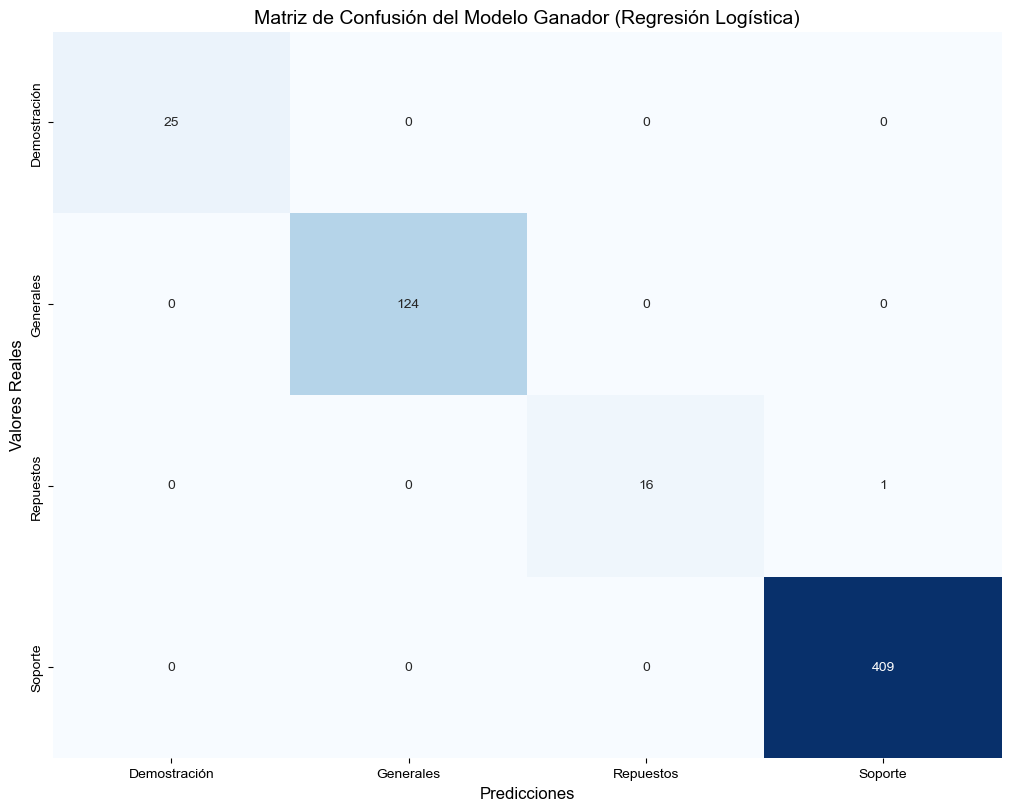


Generando Gráfico de Accuracy General de ambos modelos...


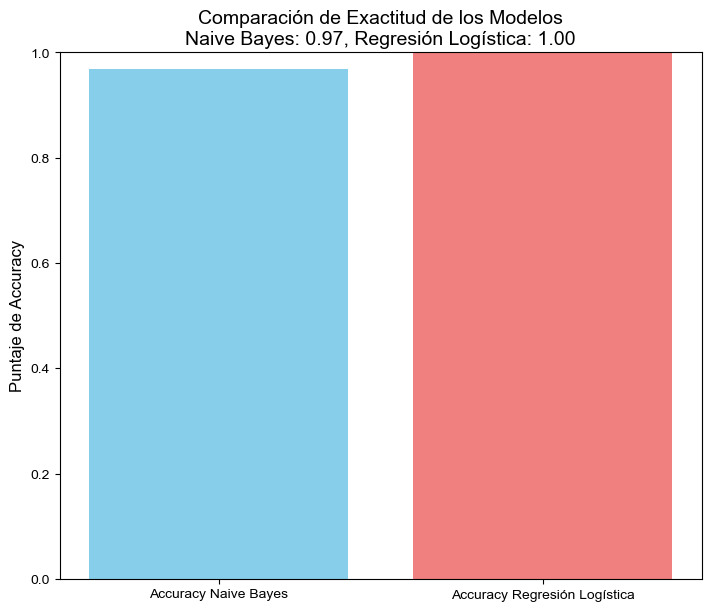


Generando Gráfico de Precision, Recall, F1-Score por Clase (Modelo Ganador - Regresión Logística)...


C:\Users\jsala\AppData\Local\Temp\ipykernel_12756\2360899983.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


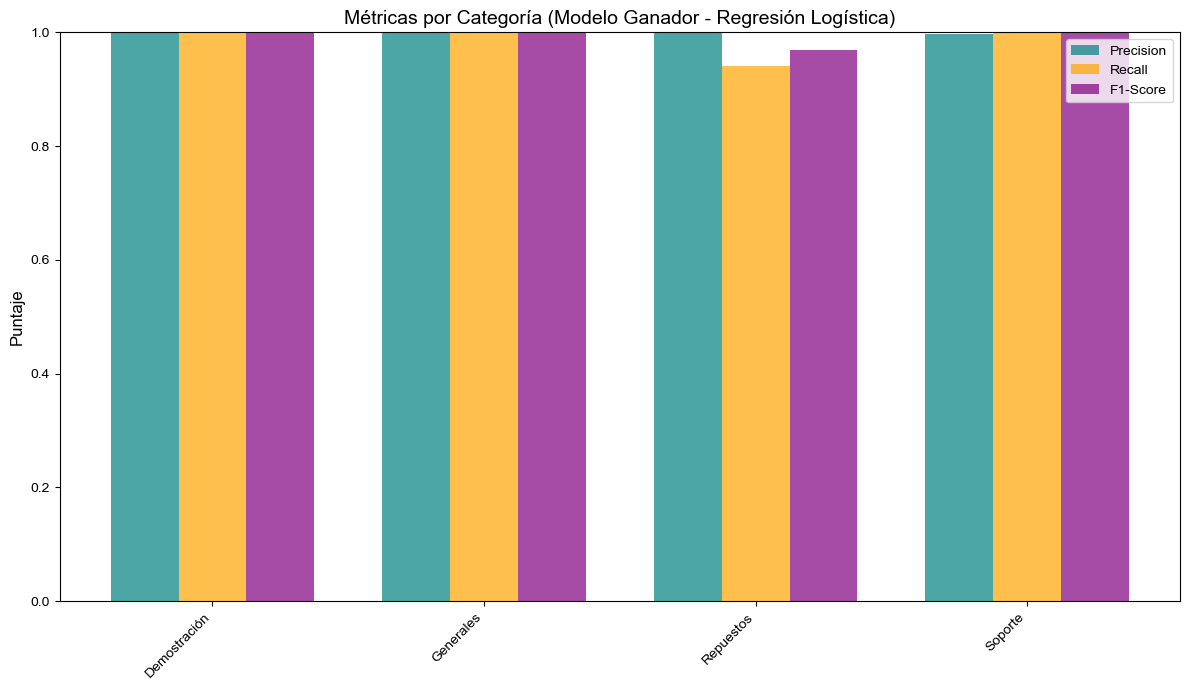


Generando Gráfico de Soporte por Categoría (Conjunto de Prueba)...


C:\Users\jsala\AppData\Local\Temp\ipykernel_12756\2360899983.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


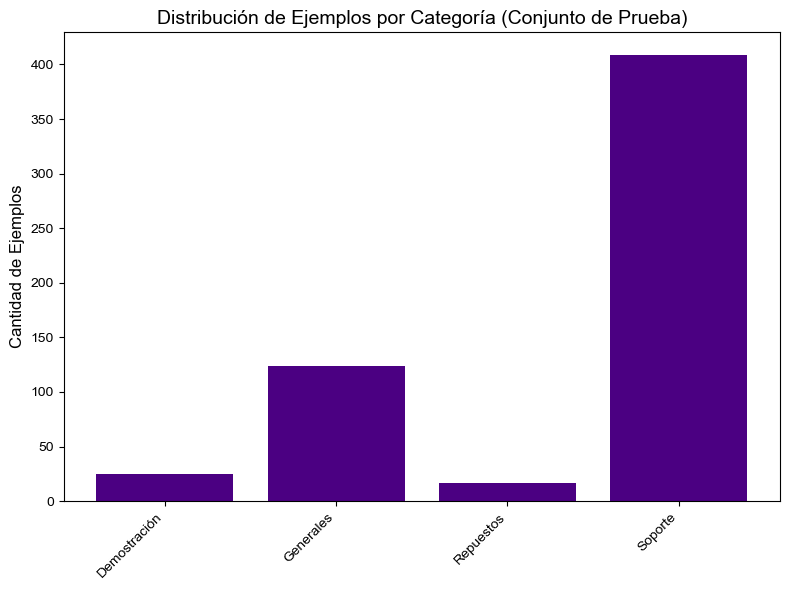

In [7]:
# ==============================================================================
# 4. Visualización de Métricas de Evaluación (CORREGIDO: Definición de 'labels')
# ==============================================================================

print("\nPaso 4: Generando Visualizaciones de Métricas de Evaluación")

# CORRECCIÓN: Definir 'labels' aquí para asegurar que siempre esté disponible.
# 'y' debe haber sido definida en el Bloque 3 (y viene de tu DataFrame 'df').
if 'y' not in locals():
    print("ERROR: La variable 'y' (etiquetas de categoría) no está definida. Asegúrate de ejecutar el Bloque 3 primero.")
    exit() # Salir si 'y' no está disponible

labels = sorted(list(y.unique())) # <--- AÑADIDO / CORREGIDO: Define 'labels' aquí.

# --- Visualización 1: Matriz de Confusión del Modelo Ganador (Regresión Logística) ---
print("\nGenerando Matriz de Confusión del Modelo Ganador (Regresión Logística)...")
# Calcula la matriz de confusión para el modelo de Regresión Logística.
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión del Modelo Ganador (Regresión Logística)')
plt.show()

# --- Visualización 2: Accuracy General de Ambos Modelos ---
print("\nGenerando Gráfico de Accuracy General de ambos modelos...")
plt.figure(figsize=(7, 6))
plt.bar(['Accuracy Naive Bayes', 'Accuracy Regresión Logística'], [acc_nb, acc_lr], color=['skyblue', 'lightcoral'])
plt.ylim(0, 1)
plt.ylabel('Puntaje de Accuracy')
plt.title(f'Comparación de Exactitud de los Modelos\nNaive Bayes: {acc_nb:.2f}, Regresión Logística: {acc_lr:.2f}')
plt.show()

# --- Visualización 3: Precision, Recall, F1-Score por Clase (Modelo Ganador) ---
print("\nGenerando Gráfico de Precision, Recall, F1-Score por Clase (Modelo Ganador - Regresión Logística)...")
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, labels=labels, average=None)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 7))
plt.bar(x - width, precision_lr, width, label='Precision', color='teal', alpha=0.7)
plt.bar(x, recall_lr, width, label='Recall', color='orange', alpha=0.7)
plt.bar(x + width, f1_lr, width, label='F1-Score', color='purple', alpha=0.7)

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Puntaje')
plt.ylim(0, 1)
plt.title('Métricas por Categoría (Modelo Ganador - Regresión Logística)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Visualización 4: Soporte (Cantidad de Ejemplos por Clase en el Conjunto de Prueba) ---
print("\nGenerando Gráfico de Soporte por Categoría (Conjunto de Prueba)...")
support = y_test.value_counts().reindex(labels).fillna(0)
plt.figure(figsize=(8, 6))
plt.bar(support.index, support.values, color='indigo')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de Ejemplos')
plt.title('Distribución de Ejemplos por Categoría (Conjunto de Prueba)')
plt.tight_layout()
plt.show()

### Bloque 5: Mecanismo de Aprendizaje Incremental

Este bloque implementa un pipeline para el aprendizaje continuo del chatbot. Permite la integración de nuevas interacciones de usuario (preguntas y respuestas) en el dataset existente, para luego re-entrenar el modelo. Esto es fundamental para que el chatbot evolucione y mejore su comprensión con el tiempo, adaptándose a nuevas necesidades y patrones de consulta.

In [8]:
# ==============================================================================
# 5. Mecanismo de Aprendizaje Incremental (Versión para Lanzamiento Inicial Estable)
# ==============================================================================

print("\nPaso 5: Configuración del Mecanismo de Aprendizaje Incremental")

def incremental_training_pipeline(new_data_path='new_questions.csv', dataset_original_path=dataset_path):
    """
    Función para cargar nuevas preguntas, actualizar el dataset, re-entrenar
    los modelos y guardar el mejor. Este proceso simula el aprendizaje continuo.
    """
    print("\nIniciando Pipeline de Aprendizaje Incremental...")

    # Cargar el dataset actual (incluyendo el original que ya ha sido limpiado y renombrado)
    # Reutilizamos la función load_and_clean_dataset que ya definimos en el Bloque 2.
    df_current = load_and_clean_dataset(dataset_original_path)

    # Verificar si existe un archivo con nuevas interacciones para añadir al dataset
    if os.path.exists(new_data_path):
        print(f"Encontrado nuevo archivo de preguntas: {new_data_path}. Concatenando...")
        
        try:
            # Asumimos que new_questions.csv tiene su cabecera en la primera fila (header=0).
            new_data = pd.read_csv(new_data_path, header=0)
        except Exception as e:
            print(f"Advertencia: No se pudieron cargar nuevas preguntas desde '{new_data_path}'. Error: {e}")
            print("Asegúrate de que el formato de 'new_questions.csv' sea correcto (ej. CATEGORIA, PREGUNTA, RESPUESTA).")
            new_data = pd.DataFrame()

        if not new_data.empty:
            # Aseguramos el mapeo de columnas para 'new_data' utilizando 'RESPUESTA' (singular)
            # para ser consistente con el dataset principal.
            new_data = new_data.rename(columns={
                'CATEGORIA': 'categoria',
                'PREGUNTA': 'pregunta',
                'RESPUESTA': 'respuesta'
            }, errors='ignore')

            # Eliminar columnas irrelevantes en new_data (SUBCATEGORIA, #) si existen.
            new_data = new_data.drop(columns=['SUBCATEGORIA', '#'], errors='ignore')

            # Aplicar limpieza de texto a las nuevas preguntas (reutilizando clean_text)
            new_data['pregunta'] = new_data['pregunta'].apply(clean_text)

            # Concatenar los datos existentes con los nuevos y eliminar duplicados.
            initial_rows = len(df_current)
            df_current = pd.concat([df_current, new_data], ignore_index=True).drop_duplicates(subset=['pregunta', 'respuesta'])
            added_rows = len(df_current) - initial_rows
            print(f"Se añadieron {added_rows} nuevas preguntas únicas al dataset.")

    else:
        print("No se encontró archivo de nuevas preguntas ('new_questions.csv'). Usando dataset existente para re-entrenamiento.")

    # Definir variables de entrada y salida actualizadas
    X_updated = df_current['pregunta']
    y_updated = df_current['categoria']

    # Vectorizar datos con el nuevo vectorizador
    vectorizer_updated = TfidfVectorizer(max_features=3000)
    X_vec_updated = vectorizer_updated.fit_transform(X_updated)

    # Dividir datos para el re-entrenamiento
    X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(
        X_vec_updated, y_updated, test_size=0.3, random_state=42
    )

    # Entrenar modelo 1: Naive Bayes (con datos actualizados)
    model_nb_updated = MultinomialNB()
    model_nb_updated.fit(X_train_updated, y_train_updated)
    y_pred_nb_updated = model_nb_updated.predict(X_test_updated)
    acc_nb_updated = accuracy_score(y_test_updated, y_pred_nb_updated)
    print("\nResultados de Naive Bayes (Actualizado):")
    print(f"Accuracy: {acc_nb_updated:.2f}")
    print(classification_report(y_test_updated, y_pred_nb_updated))

    # Entrenar modelo 2: Regresión Logística (con datos actualizados)
    model_lr_updated = LogisticRegression(max_iter=1000, solver='liblinear')
    model_lr_updated.fit(X_train_updated, y_train_updated)
    y_pred_lr_updated = model_lr_updated.predict(X_test_updated)
    acc_lr_updated = accuracy_score(y_test_updated, y_pred_lr_updated)
    print("\nResultados de Regresión Logística (Actualizado):")
    print(f"Accuracy: {acc_lr_updated:.2f}")
    print(classification_report(y_test_updated, y_pred_lr_updated))

    # Determinar modelo ganador y guardar
    if acc_nb_updated > acc_lr_updated:
        print("\nEl modelo Naive Bayes tiene mejor desempeño (Actualizado). Guardando modelo...")
        joblib.dump(model_nb_updated, 'chatbot_model.pkl')
    else:
        print("\nEl modelo de Regresión Logística tiene mejor desempeño (Actualizado). Guardando modelo...")
        joblib.dump(model_lr_updated, 'chatbot_model.pkl')

    joblib.dump(vectorizer_updated, 'tfidf_vectorizer.pkl')
    print("Modelo y vectorizador actualizados y guardados exitosamente.")

# --- La llamada a incremental_training_pipeline está COMENTADA por defecto para evitar
# --- que se ejecute en el ciclo de inicio del servidor Flask.
# incremental_training_pipeline(new_data_path='new_questions.csv


Paso 5: Configuración del Mecanismo de Aprendizaje Incremental


### Bloque 6: Crear API REST con Flask

Este es el bloque final que transforma tu modelo de Machine Learning en un servicio web accesible a través de una API REST. La aplicación Flask carga el modelo y el vectorizador entrenados, recibe preguntas de los usuarios a través de una solicitud HTTP POST, procesa la pregunta, predice la intención y devuelve la respuesta correspondiente junto con la categoría y un nivel de confianza. Se incluye un mecanismo para manejar respuestas de baja confianza.

In [ ]:
# ==============================================================================
# 6. Crear API REST con Flask (Versión para Lanzamiento Inicial Estable)
# ==============================================================================

print("\nPaso 6: Configuración de la API REST con Flask")

app = Flask(__name__)

# Cargar modelo entrenado y vectorizador al iniciar la aplicación Flask
try:
    model = joblib.load('chatbot_model.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    print("Modelo y vectorizador cargados para la API.")
except FileNotFoundError:
    print("Error: No se encontraron 'chatbot_model.pkl' o 'tfidf_vectorizer.pkl'. Por favor, asegúrate de haber ejecutado el entrenamiento (Paso 3 o 5).")
    exit()

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    user_input = data.get('pregunta', '')

    if not user_input:
        return jsonify({'error': 'No se proporcionó la pregunta en el cuerpo de la solicitud.'}), 400

    # 1. Preprocesar y vectorizar la entrada del usuario para el modelo principal
    cleaned_input = clean_text(user_input)
    input_vec = vectorizer.transform([cleaned_input])

    # 2. Hacer predicción de la categoría con el modelo principal (TF-IDF + NB/LR)
    pred_category_main = model.predict(input_vec)[0]
    probabilities_main = model.predict_proba(input_vec)[0]
    confidence_main = np.max(probabilities_main)

    # 3. Definir umbrales de confianza
    low_confidence_threshold = 0.65
    semantic_similarity_threshold = 0.8

    category_to_return = pred_category_main
    confidence_to_return = confidence_main
    respuesta_to_return = "Lo siento, no pude entender tu pregunta. ¿Podrías reformularla o preguntar algo diferente?"

    matching_responses_main = df[df['categoria'] == pred_category_main]['respuesta']
    if not matching_responses_main.empty:
        respuesta_to_return = matching_responses_main.iloc[0]

    # 4. Lógica de Manejo de Paráfrasis con Comprensión Semántica (si está disponible y es necesario)
    if semantic_model and df_embeddings is not None and confidence_to_return < low_confidence_threshold:
        print(f"Baja confianza ({confidence_to_return:.2f}) en modelo principal. Recurriendo a comprensión semántica...")
        user_embedding = semantic_model.encode([cleaned_input], convert_to_tensor=True)
        cosine_scores = util.cos_sim(user_embedding, df_embeddings)[0]

        most_similar_idx = np.argmax(cosine_scores.cpu().numpy())
        highest_semantic_score = cosine_scores[most_similar_idx].item()

        if highest_semantic_score >= semantic_similarity_threshold:
            sem_pred_category = df.iloc[most_similar_idx]['categoria']
            sem_respuesta = df.iloc[most_similar_idx]['respuesta']

            print(f"Alta similitud semántica ({highest_semantic_score:.2f}) con '{df.iloc[most_similar_idx]['pregunta']}'")
            print(f"Categoría semántica sugerida: {sem_pred_category}")

            category_to_return = sem_pred_category
            respuesta_to_return = sem_respuesta
            confidence_to_return = (confidence_main + highest_semantic_score) / 2

        else:
            print(f"Similitud semántica más alta ({highest_semantic_score:.2f}) por debajo del umbral. Manteniendo fallback.")
            category_to_return = "incertidumbre"
            respuesta_to_return = "Lo siento, no estoy seguro de cómo responder a eso. ¿Podrías reformularla o preguntar algo diferente?"

    elif confidence_to_return >= low_confidence_threshold:
         pass
    else:
        category_to_return = "incertidumbre"
        respuesta_to_return = "Lo siento, no estoy seguro de cómo responder a eso. ¿Podrías reformularla o preguntar algo diferente?"

    # Imprimir en la consola del servidor para depuración
    print(f"Input del usuario: '{user_input}'")
    print(f"Categoría final: '{category_to_return}' con confianza combinada/principal {confidence_to_return:.2f}")
    print(f"Respuesta final: '{respuesta_to_return}'") 

    # Devolver la respuesta en formato JSON
    return jsonify({
        'categoria': category_to_return,
        'respuesta': respuesta_to_return,
        'confianza': float(confidence_to_return)
    })

if __name__ == '__main__':
    print("\nIniciando la API de Flask. Accede a ella en http://0.0.0.0:5000/predict")
    print("Usa Postman o curl para enviar solicitudes POST a /predict con un JSON: {'pregunta': 'Tu pregunta aquí'}")
    # ¡IMPORTANTE!: debug=False para evitar reinicios automáticos y problemas de SystemExit
    app.run(debug=False, host='0.0.0.0', port=5000)


Paso 6: Configuración de la API REST con Flask
Modelo y vectorizador cargados para la API.

Iniciando la API de Flask. Accede a ella en http://0.0.0.0:5000/predict
Usa Postman o curl para enviar solicitudes POST a /predict con un JSON: {'pregunta': 'Tu pregunta aquí'}
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.20.28:5000
Press CTRL+C to quit
